## **OVERVIEW:**
### **Detecting Fraudulent Credit Card data**

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

For this project I will benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. I also perform effective feature engineering to improve my model's performance in a later notebook.

###**DATA**

The goal of the model we will be constructing is to accuratley predict the probability that an online transaction is fraudulent, as denoted by the binary target **isFraud**. The data is broken into two files *identity* and *transaction*, which are joined by **TransactionID**. Not all transactions have corresponding identity information.

*Categorical Features - Transaction:*
- **ProductCD**
- **card1 - card6**
- **addr1, addr2**
- **P_emaildomain**
- **R_emaildomain**
- **M1 - M9**

*Categorical Features - Identity:*
- **DeviceType**
- **DeviceInfo**
- **id_12 - id_38**


The **TransactionDT** feature is a timedelta from a given reference datetime (not an actual timestamp).

Files
- **train_{transaction, identity}.csv - the training set**
- **test_{transaction, identity}.csv - the test set (We will be predicting the isFraud value for these observations)**

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from scipy import stats
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%matplotlib inline

In [2]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# To see, how many TransactionIDs in train_transaction have an associated train_identity (%).
train_associated = np.sum(train_transaction["TransactionID"].isin(train_identity["TransactionID"].unique()))
print('We will be using %.4f percent of values from the original training dataset.'% (train_associated/len(train_transaction)*100))

We will be using 27.5918 percent of values from the original training dataset.


In [6]:
from functions_eda import missing_data_finder

print(len(missing_data_finder(train_transaction)))
missing_data_finder(train_transaction).head()

331


,column_name,missing_row_count,missing_row_percent
37,D7,328570,0.9371
14,dist2,324140,0.9245
43,D13,315030,0.8985
44,D14,313649,0.8946
42,D12,311758,0.8892


## **Merging Datasets**

In [7]:
# Combining the identity and transaction training datasets (DON'T include the test set)

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [8]:
print(len(missing_data_finder(train)))
missing_data_finder(train).head()

371


,column_name,missing_row_count,missing_row_percent
417,id_24,347357,0.9907
418,id_25,347107,0.9900
400,id_07,347094,0.9900
401,id_08,347094,0.9900
419,id_26,347092,0.9900


In [9]:
# Will not be considering the Vesta Engineered features during my modeling, so I am just going to drop all of these cols.
#train.drop(train.loc[: , 'V1':'V339'], inplace=True, axis=1)
# test.drop(test.loc[:, 'V1':'V339'], inplace=True, axis=1)

print(len(missing_data_finder(train)))
missing_data_finder(train).head()

371


,column_name,missing_row_count,missing_row_percent
417,id_24,347357,0.9907
418,id_25,347107,0.9900
400,id_07,347094,0.9900
401,id_08,347094,0.9900
419,id_26,347092,0.9900


### **ALL Column Descriptions:**
> **Transaction Features:**
- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
* **TransactionAMT**: transaction payment amount in USD
* **ProductCD**: product code, the product for each transaction
* **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
* **addr**: address
* **dist**: distance
* **P_ and (R__) emaildomain**: purchaser and recipient email domain
* **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* **D1-D15**: timedelta, such as days between previous transaction, etc.
* **M1-M9**: match, such as names on card and address, etc.

> **Identity Features:**
* **id_01 - i_11**: numerical features for identity such as device rating,      ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. A lot of these are masked however.
* **id_12 - id_38**: categorical features for identity, such as OS, Brower, their respective versions and more. Some of these are masked as well. 
* **DeviceType**: Categorical feature referring to whether the transaction occured on a mobile or desktop browser.
* **DeviceInfo**: Categorical feature regarding the make of the DeviceType(Samsung, Windows, Mac, etc).


## **Data Visualization**

#### **Target variable (isFraud) Distribution in Training set**

In [10]:
print('The percentage of fraudulent transactions in the training data set is', round(train['isFraud'].sum()/len(train['isFraud']) * 100,4),'%')
print('This shows that there is a CLASS IMBALANCE problem (will be addressed in later notebook).')
print('Class Ratio:', sum(train['isFraud'])/len(train['isFraud']))

The percentage of fraudulent transactions in the training data set is 3.3858 %
This shows that there is a CLASS IMBALANCE problem (will be addressed in later notebook).
Class Ratio: 0.03385803639931434


##### **isFraud Distribution Visualization**

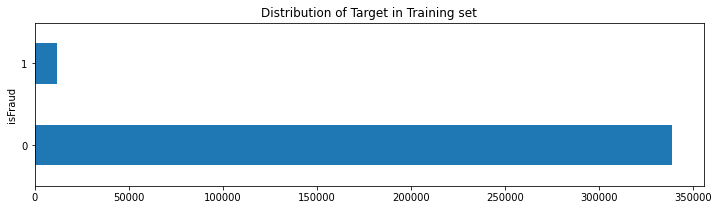

In [11]:
train.groupby('isFraud').count()['TransactionID'].plot(kind='barh',
                                                      title='Distribution of Target in Training set', figsize=(12, 3))
plt.show()

# **Transaction Feature Distribution in Training Set**
- TransactionAMT, ProductCD, card1 - card6, addr1 & addr2, P_emaildomain , R_emaildomain, C1 - C14, M1 - M9. 

**TransactionAmt Quantiles**

In [12]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

total = len(train)

Transaction Amounts Quantiles:
0.010       9.969
0.025      15.000
0.100      25.950
0.250      43.382
0.500      70.000
0.750     126.000
0.900     280.000
0.975     637.950
0.990    1091.855
Name: TransactionAmt, dtype: float64


### **TransactionAMT feature Distribution**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability')

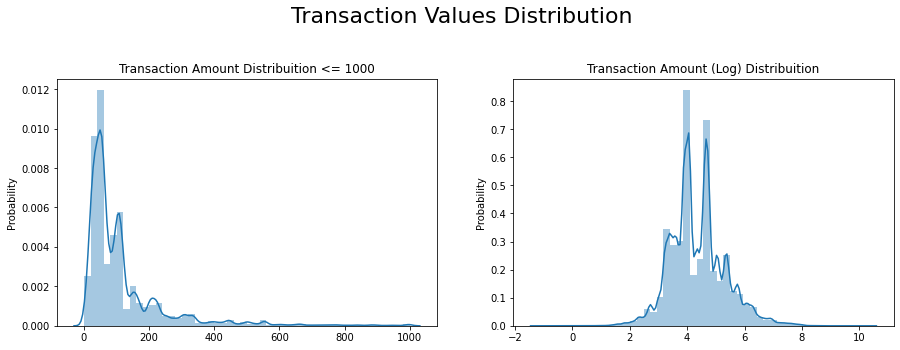

In [13]:
plt.figure(figsize=(15,10))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(train[train['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000")
g.set_xlabel("")
g.set_ylabel("Probability")

plt.subplot(222)
g1 = sns.distplot(np.log(train['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition")
g1.set_xlabel("")
g1.set_ylabel("Probability")


**Quantiles of Fraud vs. NoFruad Transactions**

In [14]:
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01          7.229     0.01          10.00
1  0.10         19.334     0.10          25.95
2  0.25         35.000     0.25          43.97
3  0.50         77.000     0.50          69.95
4  0.75        171.000     0.75         125.00
5  0.90        311.950     0.90         271.95
6  0.99        994.000     0.99        1100.00


**Calculating Outliers in TransactionAmt Data**

In [15]:
from functions_eda import calculate_outliers

calculate_outliers(train['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 5693
Total outlier observations: 5693
Non-outlier observations: 344918
Total percentual of Outliers:  1.6505


* **If we consider only values between >= 0 to 900 we will avoid the outliers and has more confidence in our distribution.**
* **We have nearly ~10k rows with outlier values that represents 1.72% of total rows.**

### **ProductCD feature Distribution**
- These values are masked, so it is hard to determine exactly what these values of *W* and *C* represent. 
- We want to look into the Distribution Products, Distribution of Frauds by Product 
- Is there a difference between Transaction Amounts in Products?

Text(0, 0.5, 'Transaction Amount')

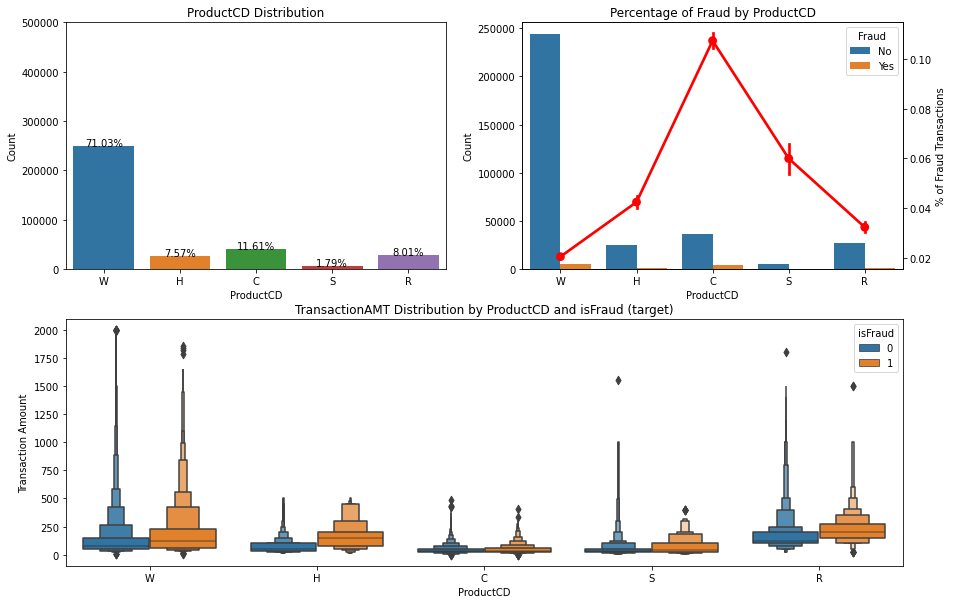

In [16]:
plt.figure(figsize = (15,10))

plt.subplot(221)
g1 = sns.countplot(x='ProductCD', data=train)
g1.set_title("ProductCD Distribution")
g1.set_xlabel("ProductCD")
g1.set_ylabel("Count")
g1.set_ylim(0,500000)

for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

plt.subplot(222)
g2 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g2.twinx()
gt = sns.pointplot(x='ProductCD', y='isFraud', data=train, color='red', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions")

g2.set_title('Percentage of Fraud by ProductCD')
g2.set_xlabel("ProductCD")
g2.set_ylabel("Count")

plt.subplot(212)
g = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g.set_title("TransactionAMT Distribution by ProductCD and isFraud (target)")
g.set_xlabel("ProductCD")
g.set_ylabel("Transaction Amount")

**We can see that *C* has the highest percent of fraud at ~11%, and *W* has the lowest percentage of fraud at ~1.5%, and that *W* has the most amount of observations. W, C and R are the most frequent values. We can also note that in W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions**


### **Card Features (card1 - card6) Distribution**
- Here we can see that only card4 and card6 have unmasked values that denote what the column is representing (card-company and card-type respectively). Even though the rest of the colums are numerical, we know that all the card features are categoricals.
- Is there a difference in transactions and % of Fraud for each values in these card features?


In [17]:
from functions_eda import full_summary_table

card = [c for c in train_transaction.columns if 'card' in c]
full_summary_table(train[card])

Dataset Shape: (350611, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int64,0,11705,13926,2755,4663,9.96
1,card2,float64,6006,499,NaN,404,490,6.30
2,card3,float64,818,102,150,150,150,0.68
3,card4,object,825,4,discover,mastercard,visa,1.11
4,card5,float64,2651,108,142,102,166,2.68
5,card6,object,822,4,credit,credit,debit,0.85


##### **Numeric card features (card1, card2, card3, card5) quantiles**

In [18]:
print("Card Feature Quantiles: ")
print(train[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Feature Quantiles: 
         card1  card2  card3  card5
0.010   1333.0  100.0  143.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  215.0  150.0  166.0
0.500   9633.0  361.0  150.0  226.0
0.750  14128.0  514.0  150.0  226.0
0.975  18004.5  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


##### **Numeric card features visualization - Card1 & Card2**

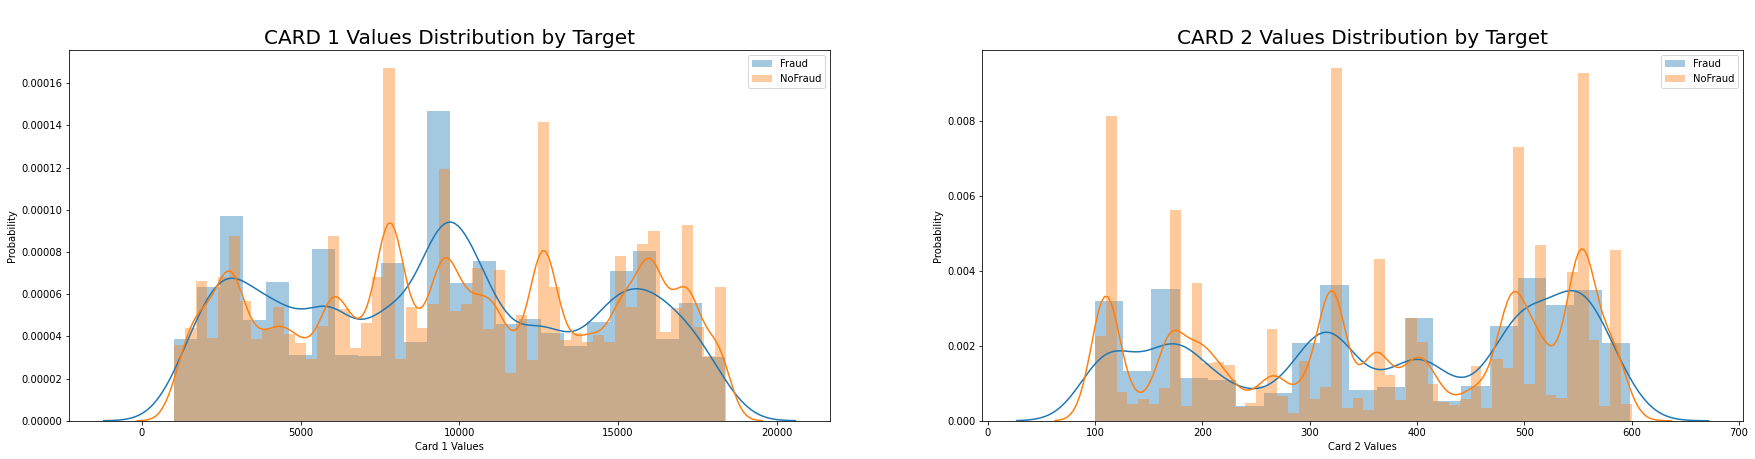

In [19]:
# This is for supressing the Warning call when using the plotting function distplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot for Card1
plt.figure(figsize=(30,15))
plt.subplot(221)

g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.set_title("\nCARD 1 Values Distribution by Target", fontsize = 20)
g.set_xlabel("Card 1 Values")
g.set_ylabel("Probability")
g.legend()

# Plot for Card2
plt.subplot(222)

g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.set_title("\nCARD 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values")
g1.set_ylabel("Probability")
g1.legend()

plt.show()

##### **Numeric card features visualization - Card3 & Card5**

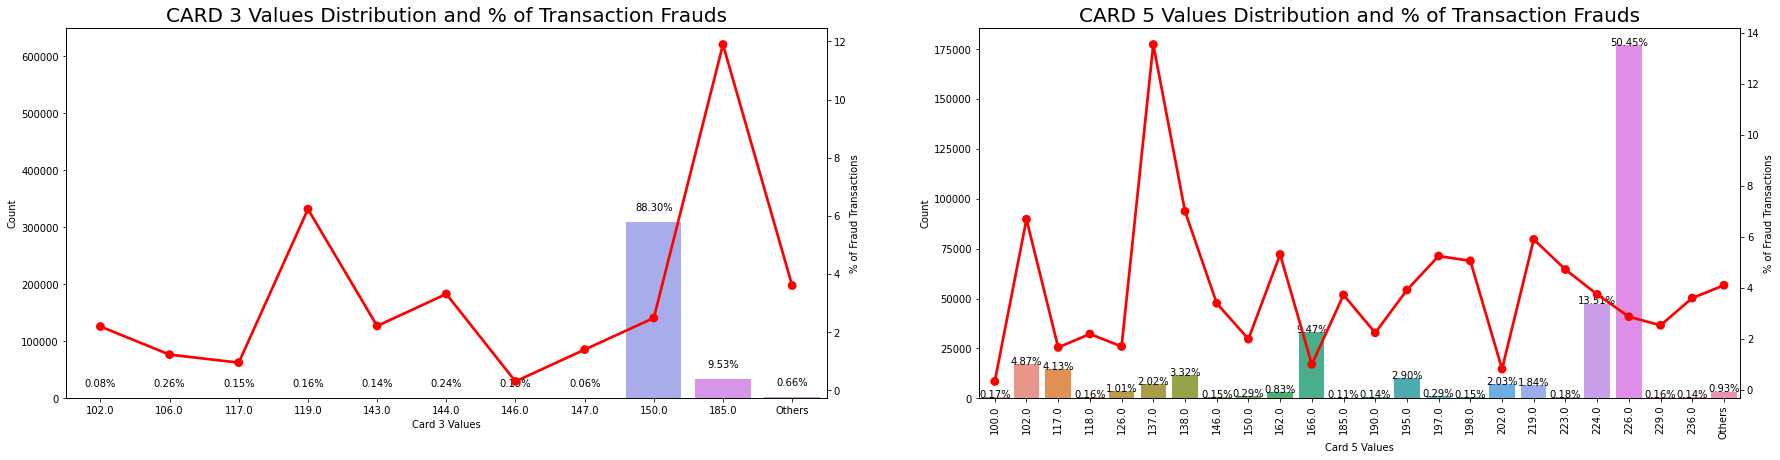

In [20]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200].index), 'card3'] = "Others"
tmp1 = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp1 = tmp1.reset_index()
tmp1.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300].index), 'card5'] = "Others"
tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(30,15))

# Plot for Card3
plt.subplot(221)
g2 = sns.countplot(x='card3', data=train, order=list(tmp1.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp1, 
                    color='red', order=list(tmp1.card3.values))
gg2.set_ylabel("% of Fraud Transactions")
g2.set_title("CARD 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values")
g2.set_ylabel("Count")
g2.set_ylim((0,650000))

for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%\n'.format(height/total*100),
            ha="center") 


#Plot for Card5
plt.subplot(222)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='red', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions")
g3.set_title("CARD 5 Values Distribution and % of Transaction Frauds",fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values")
g3.set_ylabel("Count")

for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 



* **In Card3 we can see that 150 and 185 represent the most common values in the column. The values with highest Fraud Transactions are 185 and 119, with 4.95% of Frauds in 119 and ~11% in 185**

* **In Card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also we can see the high percentage of fraudulent values in 137, 147, 141 that has few entries for values.**

##### **Categorical card features visualization - Card4**

Text(0, 0.5, 'Transaction Values')

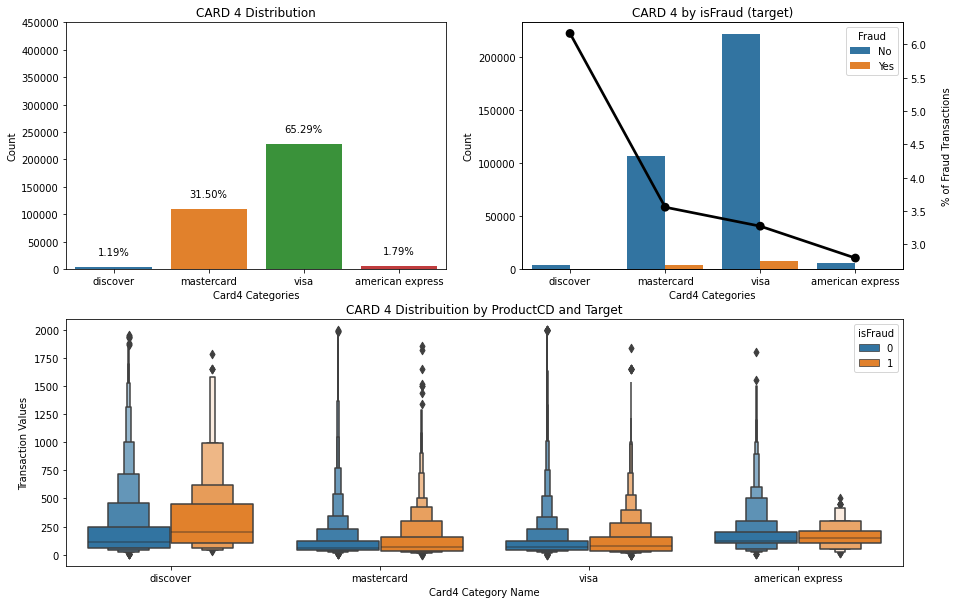

In [21]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(15,10))

#Plot 1
plt.subplot(221)
g = sns.countplot(x='card4', data=train)
g.set_title("CARD 4 Distribution")
g.set_ylim(0,450000)
g.set_xlabel("Card4 Categories")
g.set_ylabel("Count")

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%\n'.format(height/total*100),
            ha="center") 

#Plot 2
plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("\n% of Fraud Transactions")
g1.set_title("CARD 4 by isFraud (target)")
g1.set_xlabel("Card4 Categories")
g1.set_ylabel("Count")


#Plot 3
plt.subplot(212)
g = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g.set_title("CARD 4 Distribuition by ProductCD and Target")
g.set_xlabel("Card4 Category Name")
g.set_ylabel("Transaction Values")

* **We can see that 97% of our data are in Mastercard (32%) and Visa(66%)**
* **We have a highest percentage of fraudulent transactions in Discover(3.8%) against the (3.5%) in Mastercard, the (3%) in Visa and the (1.7%) in American Express.**

##### **Categorical card features visualization - Card6**

Text(0.5, 0, 'Card6 Category Name')

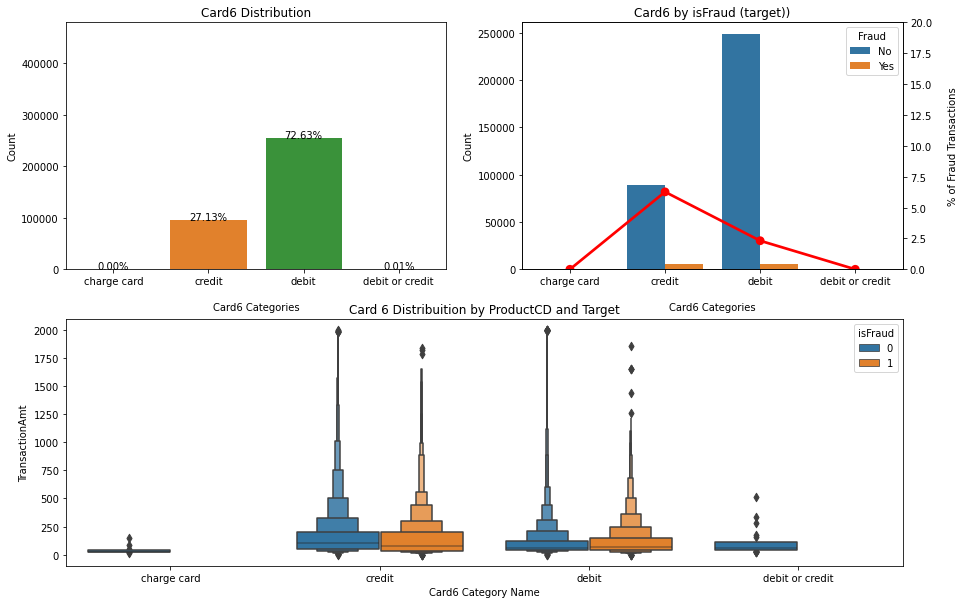

In [22]:
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(15,10))

#Plot 1
plt.subplot(221)
g = sns.countplot(x='card6', data=train, order=list(tmp.card6.values))
g.set_title("Card6 Distribution")
g.set_ylim(0,480000)
g.set_xlabel("\nCard6 Categories")
g.set_ylabel("Count")

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

#Plot 2
plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='red', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("\n% of Fraud Transactions")
g1.set_title("Card6 by isFraud (target))")
g1.set_xlabel("\nCard6 Categories")
g1.set_ylabel("Count")

#Plot 3
plt.subplot(212)
g = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train[train['TransactionAmt'] <= 2000] )
g.set_title("Card 6 Distribuition by ProductCD and Target")
g.set_xlabel("Card6 Category Name")

* **Among these plots we can see that all of our data is located either in the Credit and Debit categories.**
* **We can also see a high percentual of Frauds in Credit than Debit transactions, however the distribution of Transaction Amounts does not shows clear differences.**

## **Matching Features (M1-M9) Distributions:**

In [23]:
from functions_eda import plotting_dist_ratio

for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("none")

#### **Matching Features (M1-M9) Visualizations**

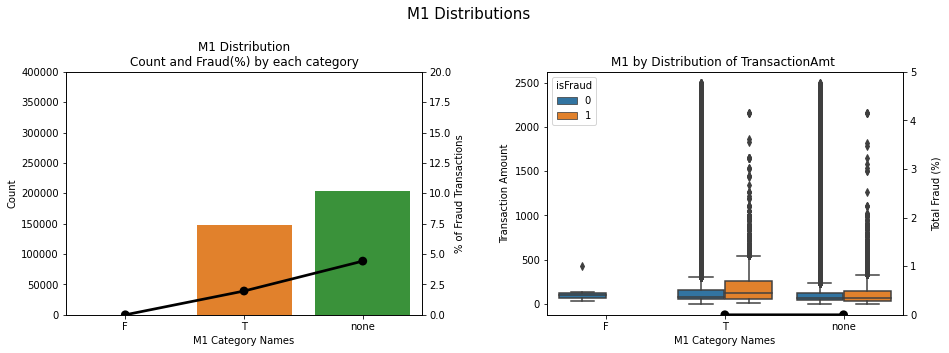

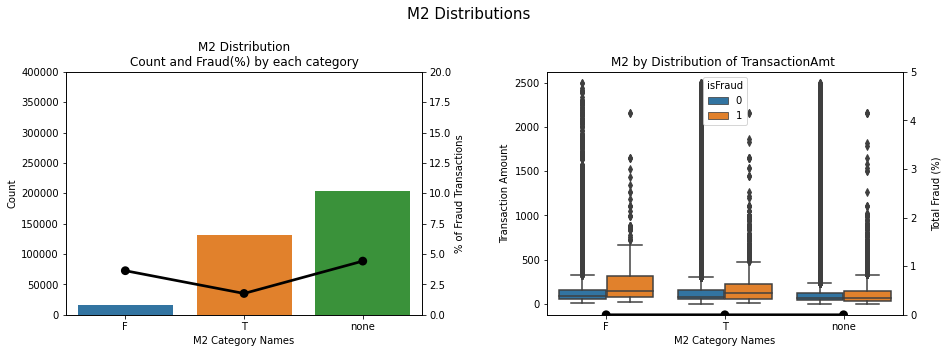

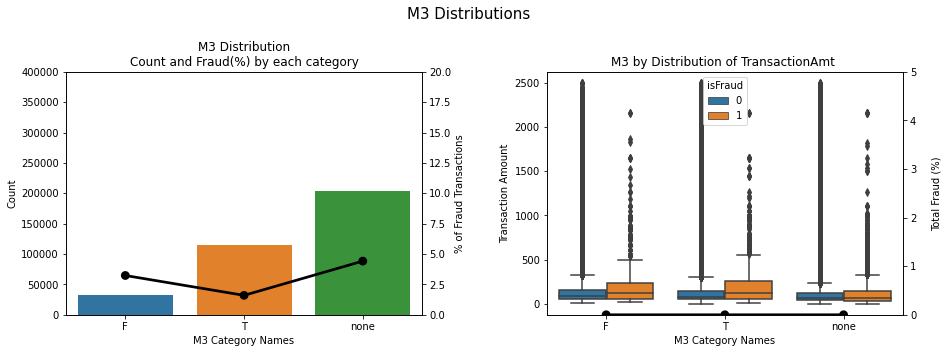

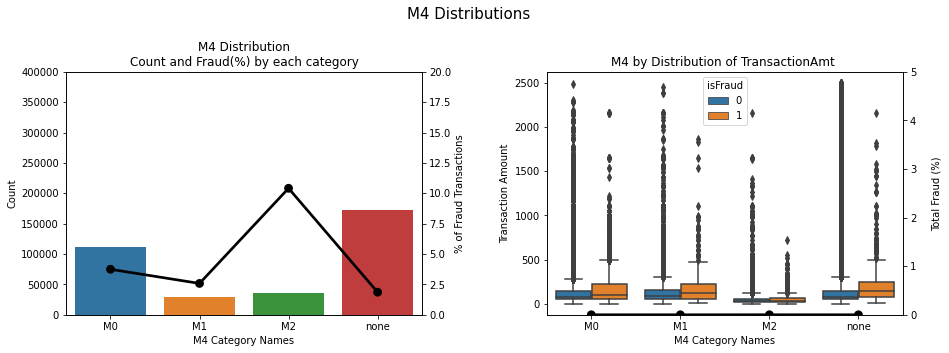

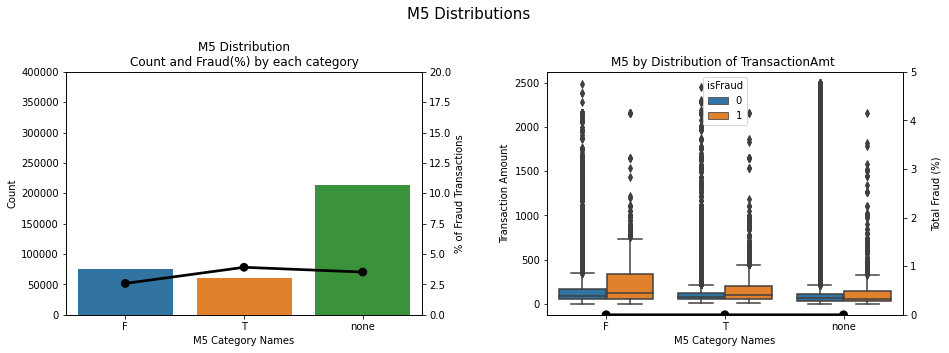

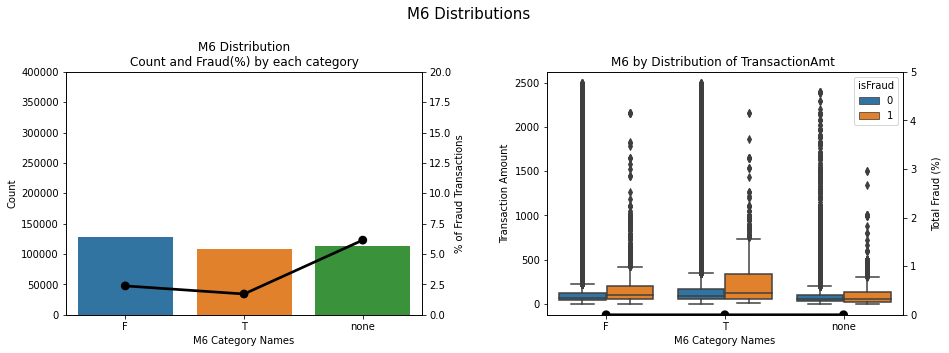

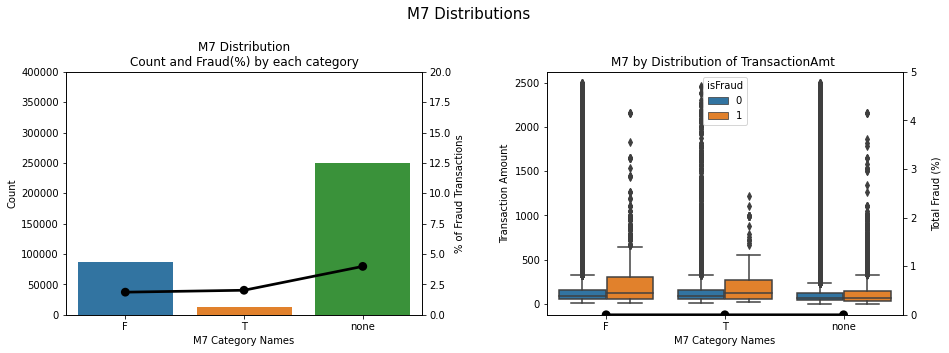

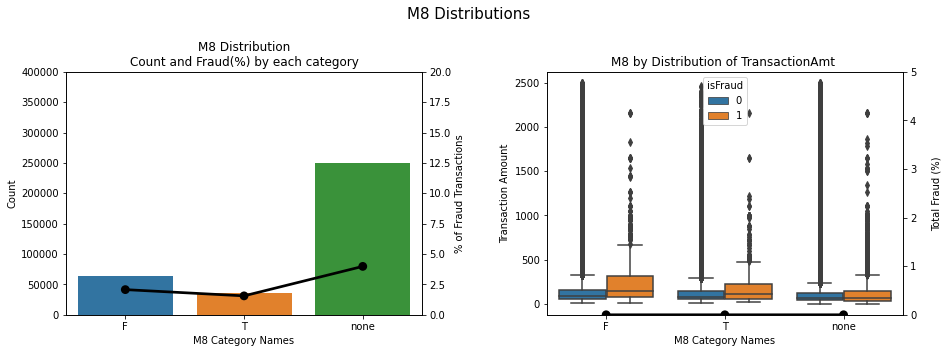

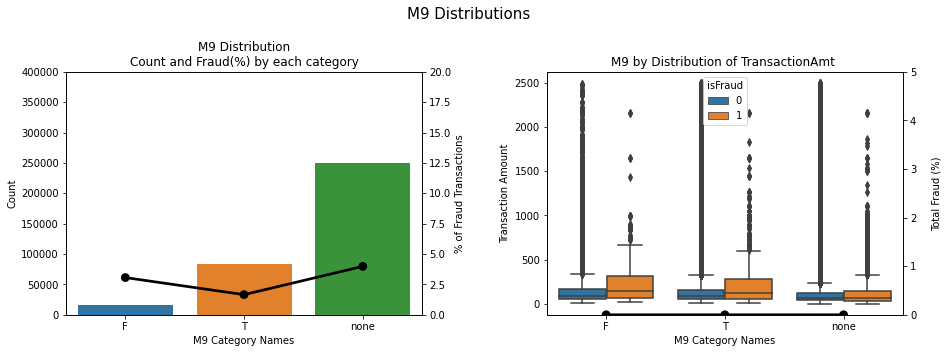

In [24]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    plotting_dist_ratio(train, col, lim=2500)

* **Even though the M features are masked, we can still gain some insightful intution regarding the distribution of these Matching Features**

## **Addr1 & Addr2 Feature Distribution**

**Addr1 & Addr2 Quantiles**

In [25]:
print("Card Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  444.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


#### **Addr1 & Addr2 Visualizations**

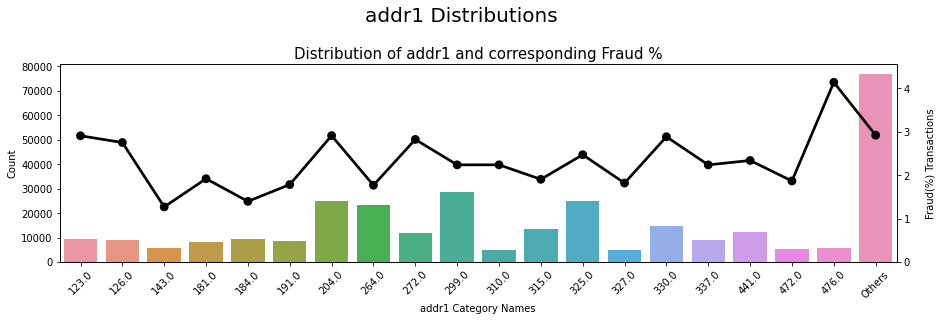

In [26]:
from functions_eda import plotting_cnt_amt

#Plot for addr1 
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"

plotting_cnt_amt(train, 'addr1')

* **There are several patterns here that are interesting to note and will help with our intution about this data**

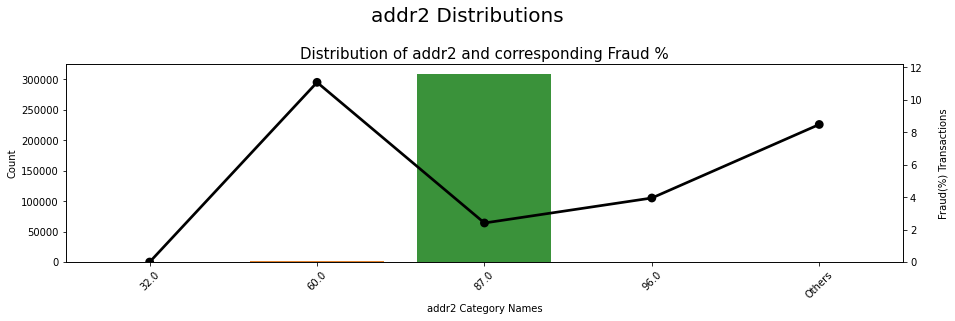

In [27]:
#Plot for addr2
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

plotting_cnt_amt(train, 'addr2')

* **It is important to note that almost all entries in Addr2 are in the same value.**
* **Interestingly for the value of 65 , the percent of frauds are almost 60%, and even though the value of 87 has 88% of total entries, the corresponding total fraud percentage is nearly 0%.**

## **P_emaildomain & R_emaildomain Distributions**

**Cleaning the email domain data**

In [28]:
#For P_emaildomain 
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)


#For R_emaildomain
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain\
                                         .value_counts()[train.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

#### **P_emaildomain & R_emaildomain Visualizations**

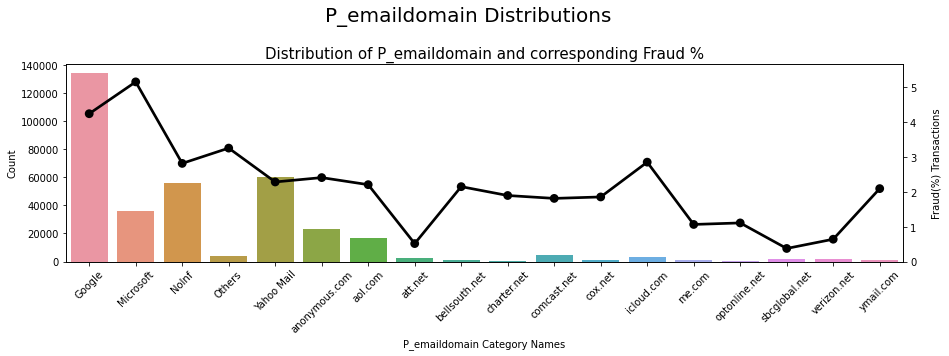

In [29]:
plotting_cnt_amt(train, 'P_emaildomain')

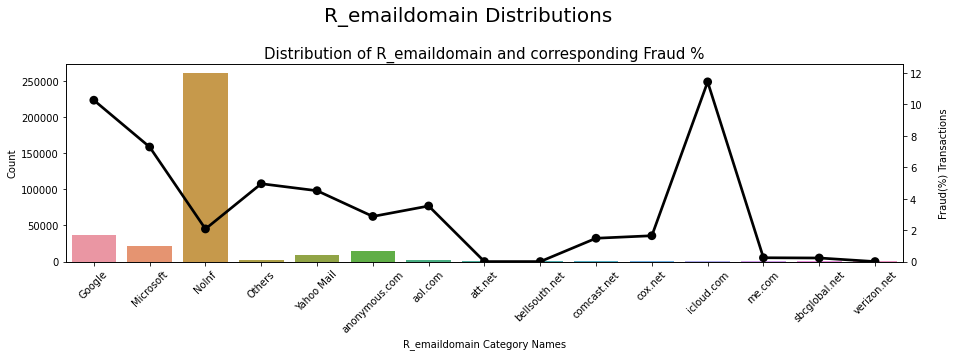

In [30]:
plotting_cnt_amt(train, 'R_emaildomain')

* **There is a very similar distributions among both the P_emaildomain and R_emaildomain values.**
* **It is also interesting to note that there are high amount of fraud among the Gopogle and iCloud email domains.**

## **Counting Features (C1-C14) Distribution**

**Summary Statistics and Data Description**

In [31]:
from functions_eda import full_summary_table
full_summary_table(train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (350611, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float64,0,1534,1.0,1.0,1.0,2.67
1,C2,float64,0,992,1.0,1.0,1.0,2.67
2,C3,float64,0,20,0.0,0.0,0.0,0.04
3,C4,float64,0,1192,0.0,0.0,0.0,1.17
4,C5,float64,0,302,0.0,0.0,0.0,2.00
5,C6,float64,0,1275,1.0,1.0,1.0,2.47
6,C7,float64,0,1086,0.0,0.0,0.0,0.72
7,C8,float64,0,1197,0.0,0.0,0.0,1.31
8,C9,float64,0,203,1.0,0.0,1.0,2.53
9,C10,float64,0,1112,0.0,0.0,0.0,1.29


In [32]:
train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000,350611.000000
mean,17.195225,18.942001,0.006049,5.795902,5.192698,10.603703,4.565236,7.775095,4.130250,7.947129,12.468462,6.444806,33.097379,9.170417
std,167.532163,194.587933,0.151075,84.741022,24.499261,86.828854,80.012705,122.740994,16.035747,123.130813,117.518161,112.299403,143.540565,58.553436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,3.000000,3.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,11.000000,2.000000
max,4685.000000,5691.000000,22.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


#### **C1 - distribution plot**

In [33]:
train.loc[train.C1.isin(train.C1\
                              .value_counts()[train.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

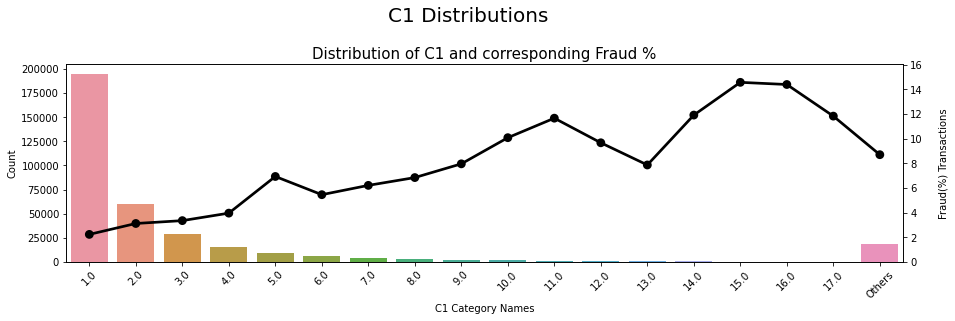

In [34]:
plotting_cnt_amt(train, 'C1')

#### **C2 - distribution plot**

In [35]:
train.loc[train.C2.isin(train.C2\
                              .value_counts()[train.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

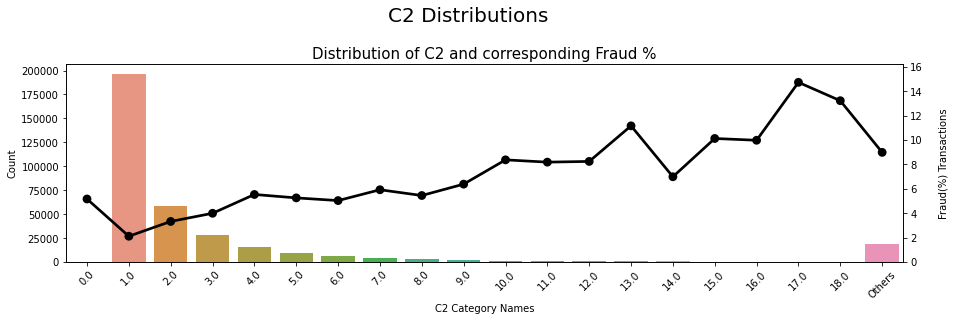

In [36]:
plotting_cnt_amt(train, 'C2')

* **I only plotted C1 and C2 distributions. For both these distributions we can see that the top 3 values are 1, 2 and 3. The percentage of fraud is higest at 11 for C1 and at 13 for C2.**

# **Identity Feature Distribution in Training Set**
- id_12 - id_38, DeviceType, DeviceInfo. 

### **Categorical ID feature distributions**

#### **ID_12-ID_29 Visualizations**

**I only included the plots for Categorical ID values that were relevant and beneficial for visualization**

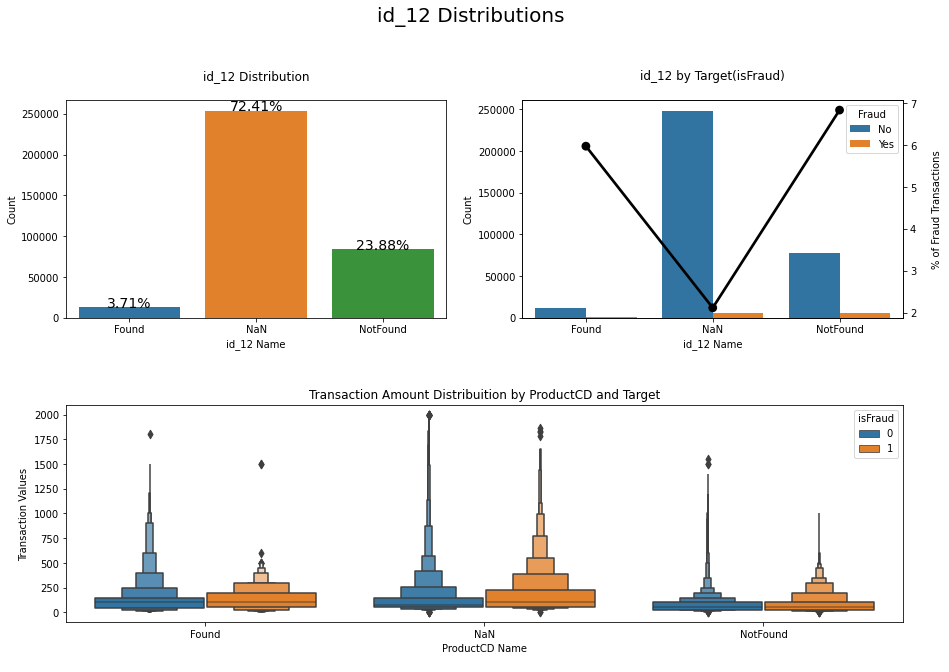

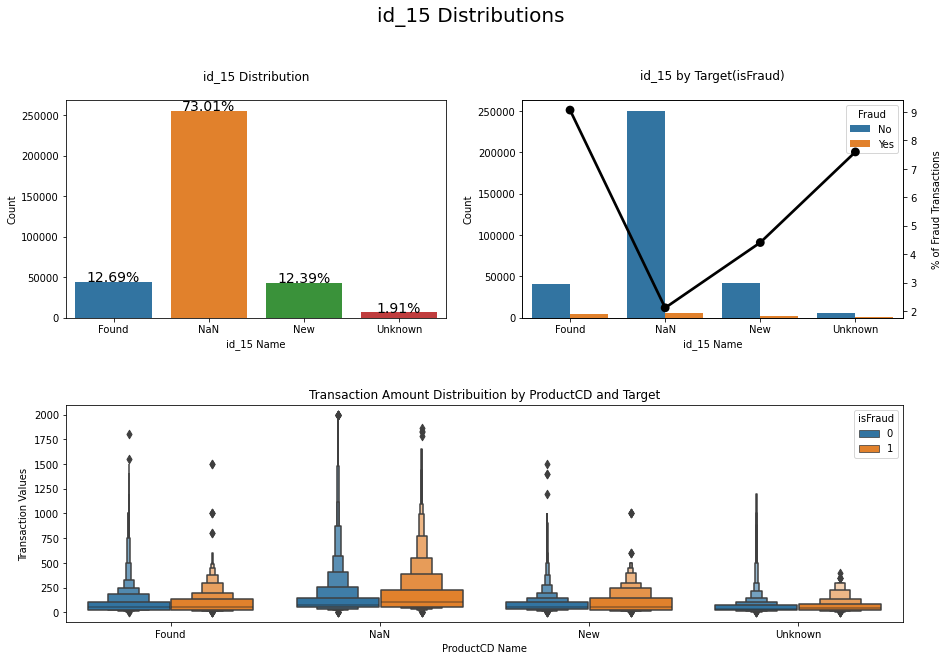

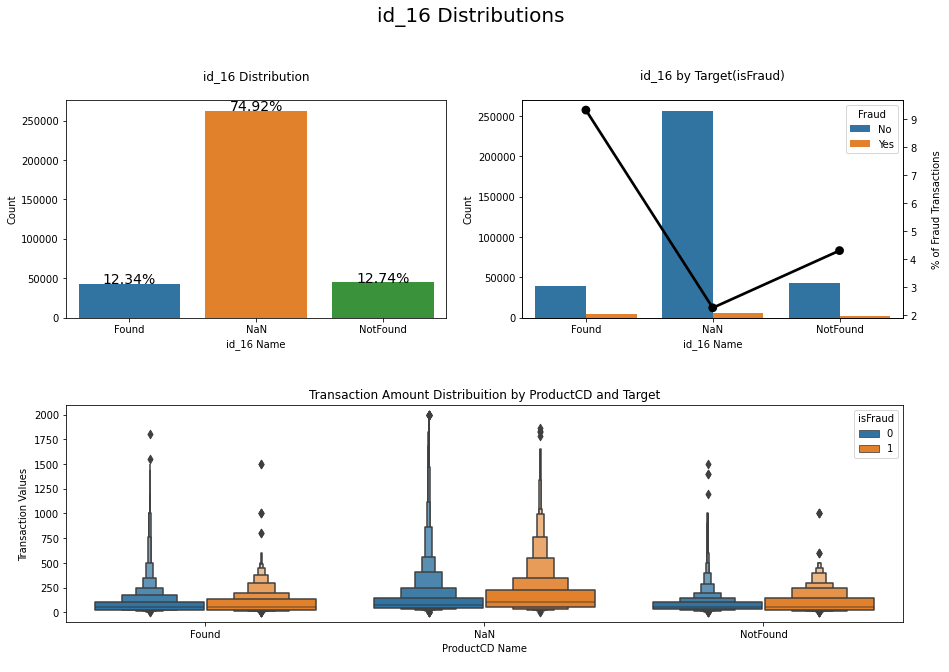

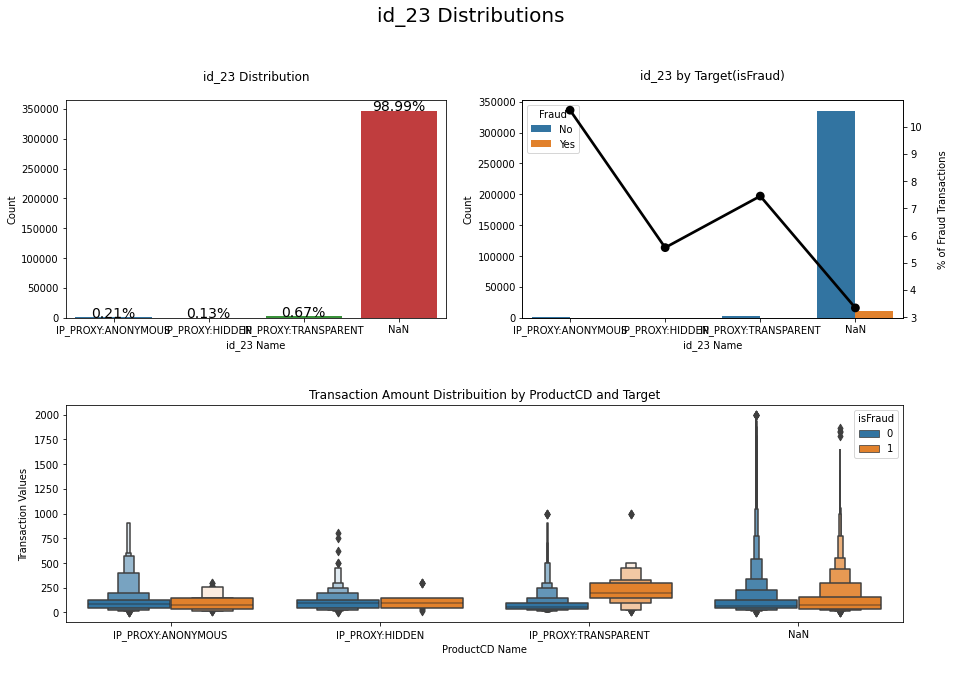

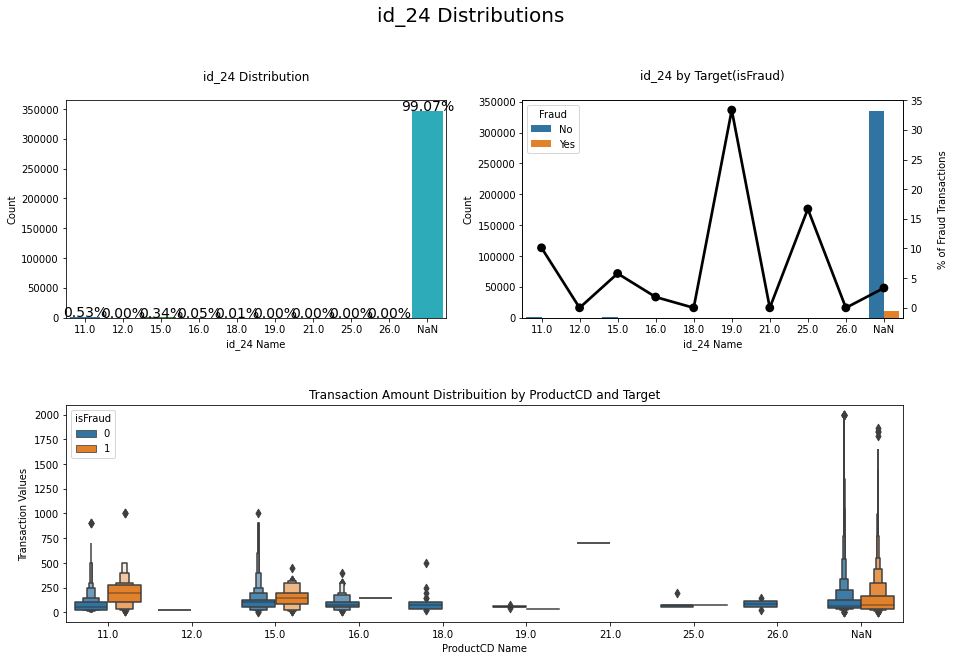

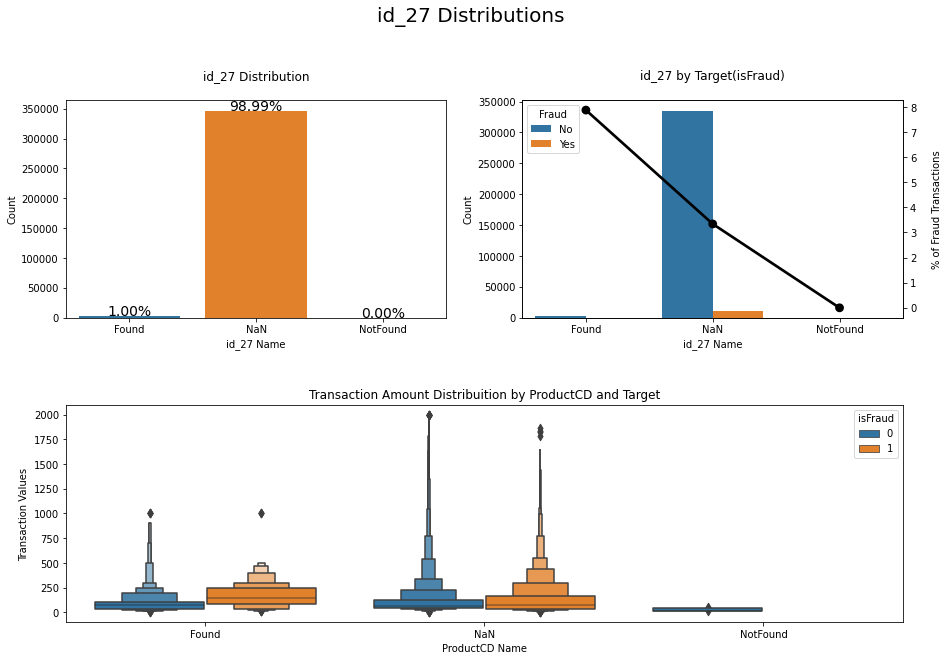

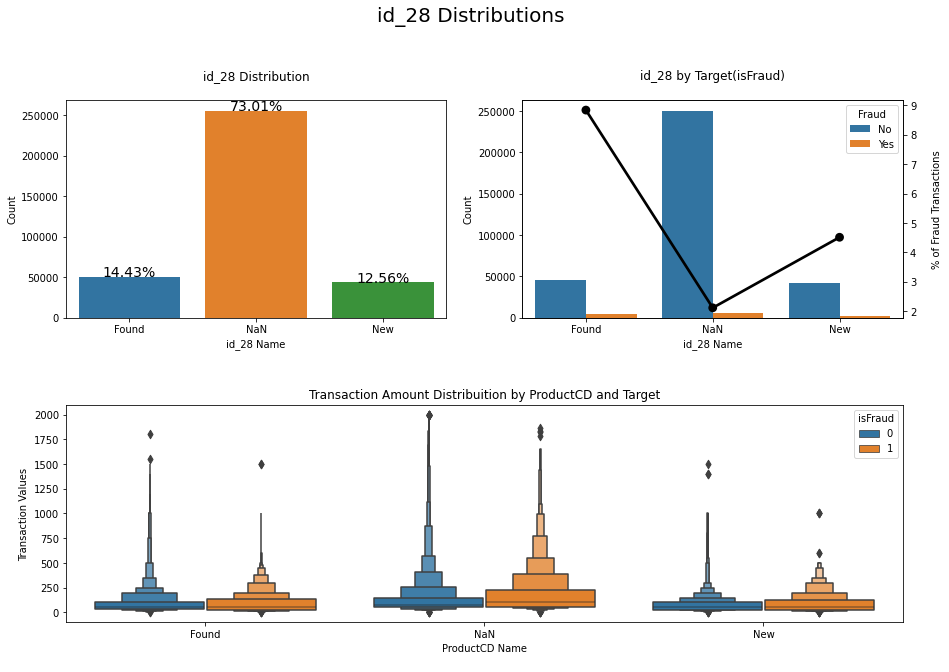

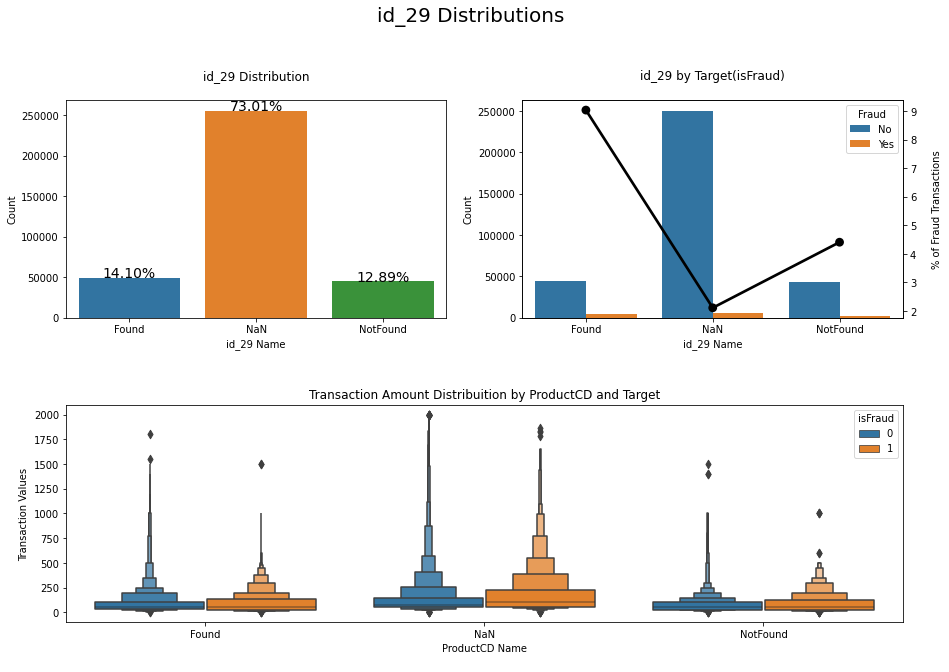

In [37]:
from functions_eda import plotting_cat_feat

for col in ['id_12', 'id_15', 'id_16','id_23','id_24','id_27','id_28', 'id_29']:
    train[col] = train[col].fillna('NaN')
    plotting_cat_feat(train, col)

#### **ID_30 & ID_31 Visualizations**

**Cleaning up the data for id_30 & id_31**

In [38]:
# ID_30
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

# ID_31
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

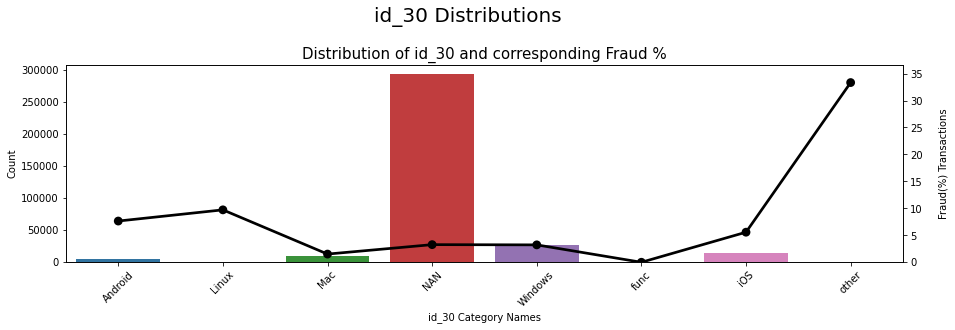

In [39]:
plotting_cnt_amt(train, 'id_30')

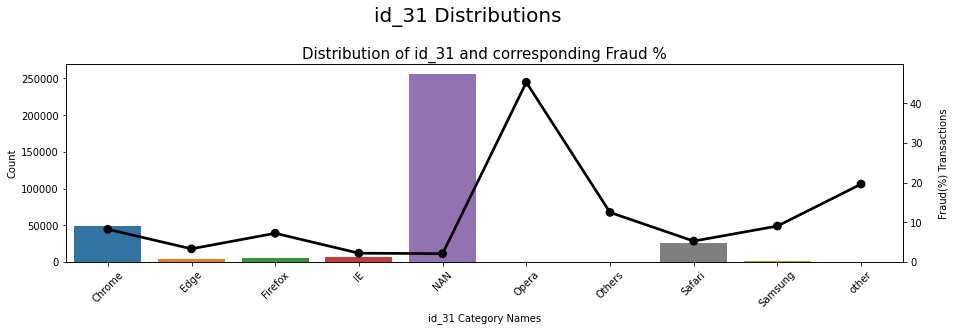

In [40]:
plotting_cnt_amt(train, 'id_31')

#### **DeviceType Visualization**

**Cleaning the DeviceType data (The DeviceInfo data is not very useful as it is different for every device and every transaction)**

In [41]:
# For DeviceType
train.loc[train['DeviceType'].str.contains('mobile', na=False), 'DeviceType'] = 'Mobile-Phone'
train.loc[train['DeviceType'].str.contains('desktop', na=False), 'DeviceType'] = 'Desktop'
train['DeviceType'].fillna("NAN", inplace=True)

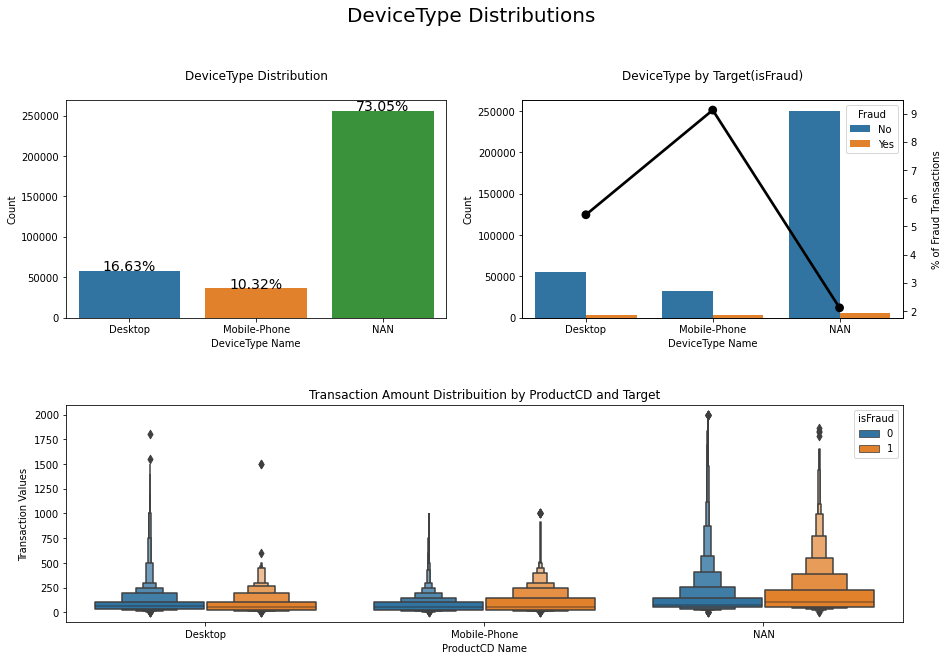

In [42]:
plotting_cat_feat(train,'DeviceType')

* **The information for DeviceType is useful as we can see the highest percentage of fraudulent transactions (~11%) occurs among mobile-phone DeviceTypes.**
* **However this distribution is highly skewed as nearly 80% of the DeviceType values are categorized as 'NaN'**

# **Timedelta features**

## **Time Features (D1-D15) distributions**

In [59]:
full_summary_table(train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
                      'D9', 'D10', 'D11', 'D12', 'D13', 'D14','D15']])

Dataset Shape: (350611, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,D1,object,6,102,14,0,0,2.99
1,D2,float64,177516,637,NaN,NaN,NaN,8.50
2,D3,float64,168450,579,13,NaN,NaN,5.61
3,D4,float64,109984,715,NaN,0,0,6.19
4,D5,float64,194612,613,NaN,NaN,NaN,5.93
5,D6,float64,307033,732,NaN,NaN,NaN,3.76
6,D7,float64,328570,521,NaN,NaN,NaN,4.32
7,D8,float64,301167,10324,NaN,NaN,NaN,11.26
8,D9,float64,301167,24,NaN,NaN,NaN,4.27
9,D10,float64,57240,732,13,0,0,5.87


In [60]:
train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
                      'D9', 'D10', 'D11', 'D12', 'D13', 'D14','D15']].describe()

,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
count,173095.000000,182161.000000,240627.000000,155999.000000,43578.000000,22041.000000,49444.000000,49444.000000,293371.000000,144191.000000,38853.000000,35581.000000,36962.000000
mean,165.707409,28.701138,130.551867,42.632267,61.230369,45.193730,154.207531,0.563469,115.385638,127.789494,49.187656,16.672606,49.032439
std,169.340114,62.118046,179.064113,87.638492,134.356580,102.991214,240.137257,0.318497,171.300415,168.918582,114.984014,66.088583,125.519897
min,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,-83.000000,0.000000,-193.000000
25%,24.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,98.000000,8.000000,19.000000,9.000000,0.000000,0.000000,43.625000,0.666666,10.000000,26.000000,0.000000,0.000000,0.000000
75%,276.000000,27.000000,243.000000,32.000000,18.000000,19.000000,197.927086,0.833333,185.000000,241.000000,9.000000,0.000000,0.000000
max,640.000000,689.000000,783.000000,757.000000,785.000000,757.000000,1707.791626,0.958333,790.000000,590.000000,583.000000,797.000000,788.000000


**D1 plot**

In [65]:
train.loc[train.D1.isin(train.D1\
                              .value_counts()[train.D1.value_counts() <= 1000 ]\
                              .index), 'D1'] = "Others"

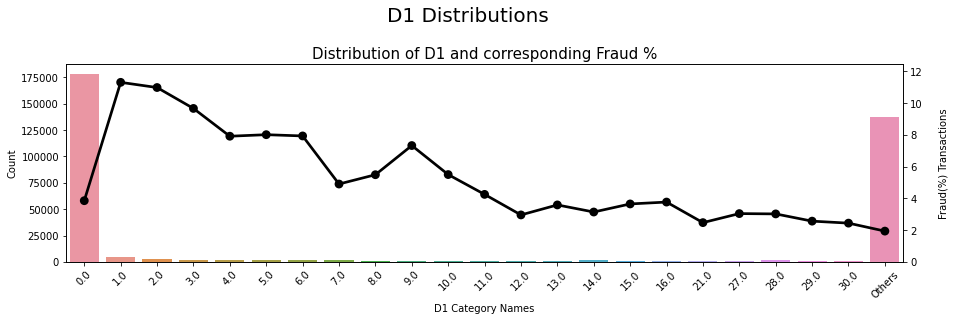

In [86]:
plotting_cnt_amt(train,'D1')

In [75]:
train.loc[train.D10.isin(train.D10\
                              .value_counts()[train.D10.value_counts() <= 1000 ]\
                              .index), 'D10'] = "Others"

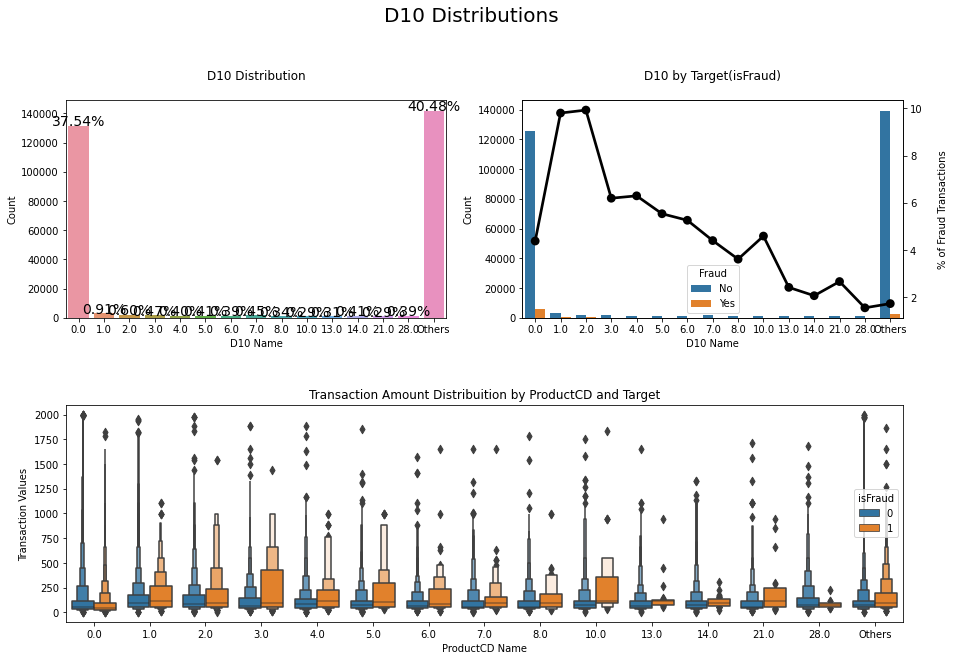

In [82]:
plotting_cat_feat(train, 'D10')

In [83]:
train.loc[train.D15.isin(train.D15\
                              .value_counts()[train.D15.value_counts() <= 1000 ]\
                              .index), 'D15'] = "Others"

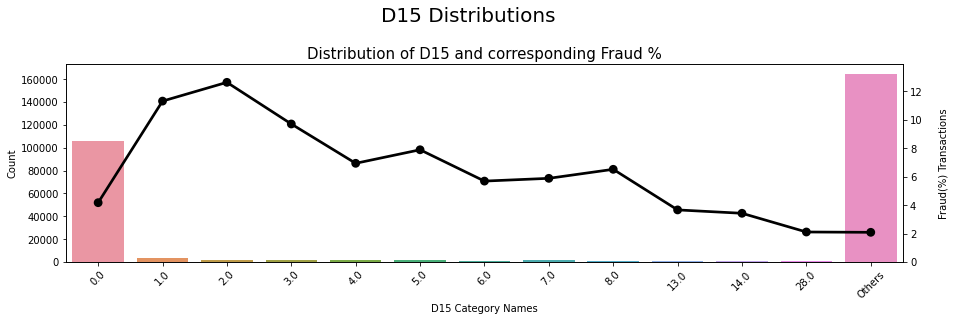

In [85]:
plotting_cnt_amt(train,'D15')

## **TransactionDT distributions**

* We are looking exploring the **TransactionDT** TimeDelta features provided in the training set to see if fraudulent transactions have some specific **HOUR/DAY/WEEKDAY** when they have the highest percentage.

**Converting TransactionDT data to Total Days, Hours and Weekdays**

In [43]:
import datetime
train_tmp = train.copy()
#Using the date December 1st, 2017 as the first date
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_tmp["Date"] = train_tmp['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

#Computing DateTime features
train_tmp['Hours'] = train_tmp['Date'].dt.hour
train_tmp['Days'] = train_tmp['Date'].dt.day
train_tmp['Weekdays'] = train_tmp['Date'].dt.dayofweek

#### **HOUR with highest TransactionAmt and Fraud (%)**

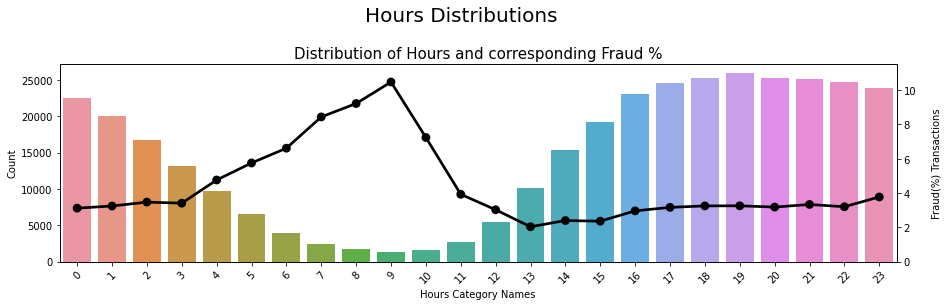

In [44]:
plotting_cnt_amt(train_tmp, 'Hours')

#### **DAYS with higest TransactionAmt and Fraud (%)**

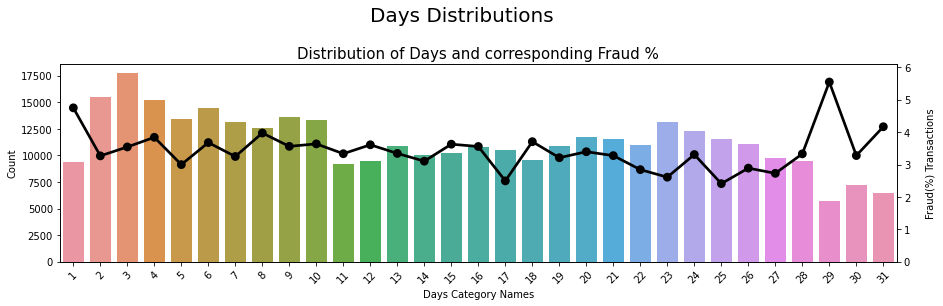

In [45]:
plotting_cnt_amt(train_tmp, 'Days')

#### **WEEKDAYS with higest TransactionAmt and Fraud (%)**

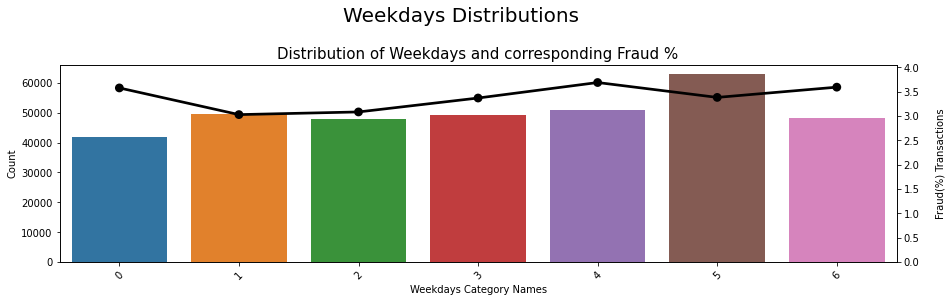

In [46]:
plotting_cnt_amt(train_tmp, 'Weekdays')

* **From these plots, we can determine that the distribution of Fraudelent transactions with respect to 'Day' and 'Weekdays' are relatively even across all the days & weekdays**
* **It is important to note that the percentage of fraudelent transactions for the Hour 8 is significantly higher compared to other hours of the day (~11%). The Hour 9 and Hour 10 also have higher fraudulent transaction rates compared to other hours as well.**